# Siamese Network on template ligand-docking dataset

In [13]:
!nvidia-smi

Thu Feb 24 15:30:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    19W / 240W |    586MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [15]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [17]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [18]:
path = Path('../dataset/oldsmiledata')

In [19]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/valid_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [20]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_balanced_{dataset}.csv', index_col=0)
valid = pd.read_csv(path/f'valid_balanced_{dataset}.csv', index_col=0)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19624
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19625 non-null  object 
 1   docked                          19625 non-null  object 
 2   rmsd                            19625 non-null  float64
 3   uniprot_id                      19625 non-null  object 
 4   smiles_template                 19625 non-null  object 
 5   smiles_docked                   19625 non-null  object 
 6   mcs_smartsString                19625 non-null  object 
 7   template_HeavyAtomCount         19625 non-null  int64  
 8   template_NHOHCount              19625 non-null  int64  
 9   template_NOCount                19625 non-null  int64  
 10  template_RingCount              19625 non-null  int64  
 11  template_NumHAcceptors          19625 non-null  int64  
 12  template_NumHDonors             

In [22]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5322
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        5323 non-null   object 
 1   docked                          5323 non-null   object 
 2   rmsd                            5323 non-null   float64
 3   uniprot_id                      5323 non-null   object 
 4   smiles_template                 5323 non-null   object 
 5   smiles_docked                   5323 non-null   object 
 6   mcs_smartsString                5323 non-null   object 
 7   template_HeavyAtomCount         5323 non-null   int64  
 8   template_NHOHCount              5323 non-null   int64  
 9   template_NOCount                5323 non-null   int64  
 10  template_RingCount              5323 non-null   int64  
 11  template_NumHAcceptors          5323 non-null   int64  
 12  template_NumHDonors             53

In [23]:
train.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid
0,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,8,...,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709,False
1,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,6,...,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614,False
2,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,8,...,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630,False
3,1C1U_BAI,2C8W_C7M,4.928,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,COc1ccc(S(=O)(=O)NC[C@@H](O)[C@H](Cc2ccccc2)[N...,"[#6]-,:[#6]:[#6]:[#6]:[#6](:,-[#7]:,-[#6]):[#6...",22,5,6,...,0,1,2,0.139037,0.157609,1.594933,3,-0.609626,-1.423913,False
4,5AFY_WCE,3SV2_P05,7.608,P00734,NC(=O)c1cccc(Cl)c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1ccncc1,"[#7]-[#6](=[#8])-[#6]:,-[#6]:,-[#6]:[#6]:[#6]:...",10,2,2,...,0,1,4,0.116071,0.157407,2.029200,3,-0.839286,-1.425926,False


# Preprocessing

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

### Splitting the data into train and validation sets

In [25]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19624
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19625 non-null  object 
 1   docked                          19625 non-null  object 
 2   rmsd                            19625 non-null  float64
 3   uniprot_id                      19625 non-null  object 
 4   smiles_template                 19625 non-null  object 
 5   smiles_docked                   19625 non-null  object 
 6   mcs_smartsString                19625 non-null  object 
 7   template_HeavyAtomCount         19625 non-null  int64  
 8   template_NHOHCount              19625 non-null  int64  
 9   template_NOCount                19625 non-null  int64  
 10  template_RingCount              19625 non-null  int64  
 11  template_NumHAcceptors          19625 non-null  int64  
 12  template_NumHDonors             

In [26]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5322
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        5323 non-null   object 
 1   docked                          5323 non-null   object 
 2   rmsd                            5323 non-null   float64
 3   uniprot_id                      5323 non-null   object 
 4   smiles_template                 5323 non-null   object 
 5   smiles_docked                   5323 non-null   object 
 6   mcs_smartsString                5323 non-null   object 
 7   template_HeavyAtomCount         5323 non-null   int64  
 8   template_NHOHCount              5323 non-null   int64  
 9   template_NOCount                5323 non-null   int64  
 10  template_RingCount              5323 non-null   int64  
 11  template_NumHAcceptors          5323 non-null   int64  
 12  template_NumHDonors             53

In [27]:
# image size 224,224
target_shape=(224, 224)

In [28]:
train_good = train[train.log_RMSD <= 1.5]
train_good = train_good.reset_index(drop=True)
train_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        8165 non-null   object 
 1   docked                          8165 non-null   object 
 2   rmsd                            8165 non-null   float64
 3   uniprot_id                      8165 non-null   object 
 4   smiles_template                 8165 non-null   object 
 5   smiles_docked                   8165 non-null   object 
 6   mcs_smartsString                8165 non-null   object 
 7   template_HeavyAtomCount         8165 non-null   int64  
 8   template_NHOHCount              8165 non-null   int64  
 9   template_NOCount                8165 non-null   int64  
 10  template_RingCount              8165 non-null   int64  
 11  template_NumHAcceptors          8165 non-null   int64  
 12  template_NumHDonors             81

In [29]:
negative = train[train.log_RMSD > 2.1]
negative = negative.reset_index(drop=True)
len(negative)

4994

In [30]:
valid_good = valid[valid.log_RMSD <= 1.5]
valid_good = valid_good.reset_index(drop=True)
len(valid_good)

2230

In [31]:
val_negative = valid[valid.log_RMSD > 2]
val_negative = val_negative.reset_index(drop=True)
len(val_negative)

1770

In [32]:
IMAGES = '../dataset/oldsmiledata/mol_images/all/'

In [33]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_png(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = tf.transpose(image)
    return image

In [34]:
%%capture
#img_shape = preprocess_image(train.img_temp[0]).shape

In [35]:
#img_shape

In [36]:
!nvidia-smi

Thu Feb 24 15:31:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    21W / 240W |    598MiB /  8116MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

2022-02-24 15:31:50.269709: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-24 15:31:50.271112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-24 15:31:50.350833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 15:31:50.351373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2022-02-24 15:31:50.351396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-24 15:31:50.352706: I tensorflow/stream_executor/platform/d

In [38]:
def preprocess_triplets(template, docked, negative, rmsd):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(template), preprocess_image(docked), preprocess_image(negative), rmsd)
    

In [39]:
def preprocess_triplets_2(tup, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(tup[0]),
        preprocess_image(tup[1]),
        preprocess_image(negative))

In [40]:
#image = preprocess_image('/4A7I_A7I.png')
#image.shape

In [41]:
train_template_images = [r.img_temp for i, r in train_good.iterrows()]

In [42]:
train_docked_images = [r.img_docked for i, r in train_good.iterrows()]

In [43]:
len(train_template_images), len(train_docked_images)

(8165, 8165)

In [44]:
def find_negative_train(docked):
    negs = negative[negative.docked == docked]
    negs = negs.reset_index(drop=True)
    if len(negs) > 0:
        i = random.randint(0,len(negs) - 1)
        neg = negs.iloc[i]
    else:
        i = random.randint(0,len(negative) - 1)
        neg = negative.iloc[i]
    return neg.img_docked

In [45]:
def find_negative_val(docked):
    negs = val_negative[val_negative.docked == docked]
    negs = negs.reset_index(drop=True)
    if len(negs) > 0:
        i = random.randint(0,len(negs) - 1)
        neg = negs.iloc[i]
    else:
        i = random.randint(0,len(val_negative) - 1)
        neg = val_negative.iloc[i]
    return neg.img_docked

In [46]:
valid_template_images = [r.img_temp for i, r in valid_good.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid_good.iterrows()]

In [47]:
import tensorflow as tf
print('Num GPus avalable: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPus avalable:  1


In [50]:
negative_images = [find_negative_train(r.docked) for i, r in train_good.iterrows()]
#np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
#negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [51]:
val_negative_images = [find_negative_val(r.docked) for i, r in valid_good.iterrows()]
#np.random.RandomState(seed=32).shuffle(negative_images)

val_negative_dataset = tf.data.Dataset.from_tensor_slices(val_negative_images)
#val_negative_dataset = val_negative_dataset.shuffle(buffer_size=4096)

In [54]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

10395

In [53]:
neg_image_count = len(negative_images) + len(val_negative_images)
neg_image_count

10395

In [55]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [56]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [57]:
y_train = train['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))


In [58]:
y_valid = valid['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

In [59]:
log_rmsd = [r.log_RMSD for i, r in train_good.iterrows()]
val_log_rmsd = [r.log_RMSD for i, r in valid_good.iterrows()]

In [60]:
log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(log_rmsd)
val_log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(val_log_rmsd)

In [61]:
!nvidia-smi

Thu Feb 24 15:33:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   62C    P2    53W / 240W |    823MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Create the train and validation datasets

In [62]:
train_dataset = tf.data.Dataset.zip((docked_dataset, template_dataset, negative_dataset, log_rmsd_dataset)) # template as anchor
#train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset, negative_dataset)) # template as anchor
valid_dataset = tf.data.Dataset.zip((val_docked_dataset, val_template_dataset, val_negative_dataset, val_log_rmsd_dataset)) # template as anchor
#valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset, val_negative_dataset)) # template as anchor
train_dataset, valid_dataset

(<ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>,
 <ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>)

In [63]:
train_dataset = train_dataset.take(round(image_count * 1))
train_dataset

<TakeDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>

In [64]:
train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = valid_dataset.map(preprocess_triplets)
train_dataset, val_dataset

(<MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>,
 <MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>)

In [65]:
train_dl = train_dataset.batch(32, drop_remainder=True)
train_dl = train_dl.prefetch(8)
train_dl

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3), (32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [66]:
val_dl = val_dataset.batch(32, drop_remainder=True)
val_dl = val_dl.prefetch(8)
val_dl

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3), (32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

## Anchor, positive and the distance between them computed by the distance layer

2022-02-24 15:34:31.835717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-24 15:34:31.854708: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3999980000 Hz


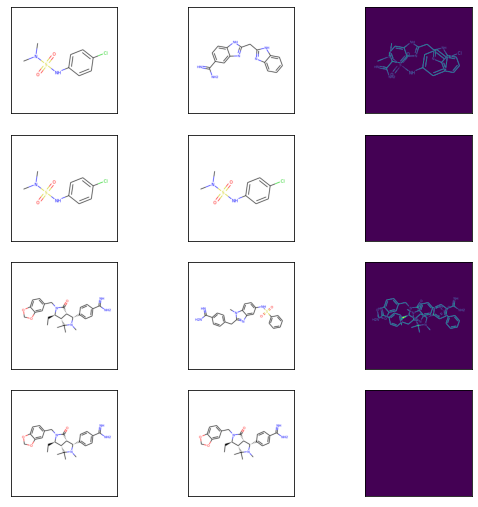

In [67]:
def visualize(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(0, 4, 2):
        show(axs[i, 0], anchor[i])
        show(axs[i + 1, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i + 1, 1], negative[i])
        ap_distance = tf.reduce_sum(tf.square(anchor[i] - positive[i]), -1)
        an_distance = tf.reduce_sum(tf.square(anchor[i] - negative[i]), -1)
        show(axs[i, 2], ap_distance)
        show(axs[i + 1, 2], an_distance)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss, 0.0)
    


visualize(*list(val_dl.take(1).as_numpy_iterator())[0])

## Anchor, positive and the negative image

1.3719418
1.3045418
1.3134549


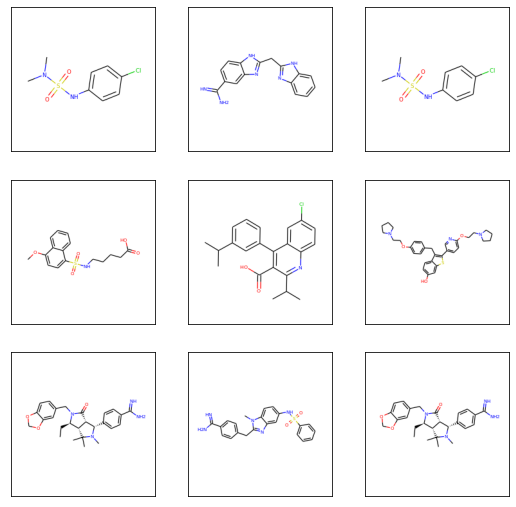

In [68]:
def visualize2(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        print(rmsd[i])
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize2(*list(val_dl.take(1).as_numpy_iterator())[0])

In [69]:
def visualize_positive(anchor, positive):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(1, 2))

    axs = fig.subplots(1, 2)
    show(axs[0, 0], anchor)
    show(axs[0, 1], positive)

# Siamese network with distance layer and RMSD as mmargin in loss function

### Idea is to use RMSD instead of a set margin to allow a bigger loss to ligands with bigger RMSD scores

In [70]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape +  (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [71]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative, rmsd):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance, rmsd)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))
rmsd_input = layers.Input(name='rmsd', shape=(1))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
    rmsd_input,
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input, rmsd_input], outputs=distances
)

siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 224, 224, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

### Triplet loss defined as: 

$$\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)$$

In [75]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=1.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.rmse_tracker = metrics.RootMeanSquaredError(name="rmse")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        ap_distance, an_distance, rmsd = self.siamese_network(data)
        # Let's update and return the loss metric and rmse metric.
        self.loss_tracker.update_state(loss)
        distance = ap_distance - an_distance
        # RMSE (Euclidean distance) between anchor and positive image minus RMSD
        rmse = tf.maximum(distance, 0.0)
        self.rmse_tracker.update_state(self.amrgin - rmsd, rmse)
        return {"loss": self.loss_tracker.result(), 'rmse': self.rmse_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance, rmsd = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin - rmsd, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.rmse_tracker]


### Choose optimizer and train model

In [76]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [77]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=metrics.RootMeanSquaredError(name='rmse'))

In [78]:
history = siamese_model.fit(train_dl, validation_data=val_dl, epochs=10) # save

Epoch 1/10


2022-02-24 15:35:59.787631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-24 15:35:59.973316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-24 15:36:00.550167: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-24 15:36:00.581791: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-24 15:36:18.288629: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-24 15:3

255/255 [==============================] - 127s 399ms/step - loss: 0.9062 - val_loss: 0.7757 - val_rmse: 0.1314
Epoch 2/10
255/255 [==============================] - 100s 391ms/step - loss: 0.7283 - val_loss: 0.6892 - val_rmse: 0.1383
Epoch 3/10
255/255 [==============================] - 99s 389ms/step - loss: 0.6762 - val_loss: 0.6565 - val_rmse: 0.1965
Epoch 4/10
255/255 [==============================] - 99s 390ms/step - loss: 0.6534 - val_loss: 0.6300 - val_rmse: 0.1699
Epoch 5/10
255/255 [==============================] - 99s 390ms/step - loss: 0.6379 - val_loss: 0.6190 - val_rmse: 0.1685
Epoch 6/10
255/255 [==============================] - 99s 390ms/step - loss: 0.6293 - val_loss: 0.6083 - val_rmse: 0.1574
Epoch 7/10
255/255 [==============================] - 99s 390ms/step - loss: 0.6230 - val_loss: 0.5994 - val_rmse: 0.1336
Epoch 8/10
255/255 [==============================] - 99s 390ms/step - loss: 0.6180 - val_loss: 0.5942 - val_rmse: 0.1406
Epoch 9/10
255/255 [=============

### RMSE as difference between rmsd and ap - an distances

In [79]:
history = siamese_model.fit(train_dl, validation_data=val_dl, epochs=10)

Epoch 1/10
255/255 [==============================] - 100s 392ms/step - loss: 0.6096 - val_loss: 0.5829 - val_rmse: 0.1029
Epoch 2/10
255/255 [==============================] - 99s 389ms/step - loss: 0.6066 - val_loss: 0.5808 - val_rmse: 0.1156
Epoch 3/10
255/255 [==============================] - 100s 394ms/step - loss: 0.6054 - val_loss: 0.5796 - val_rmse: 0.1011
Epoch 4/10
255/255 [==============================] - 101s 396ms/step - loss: 0.6023 - val_loss: 0.5784 - val_rmse: 0.1266
Epoch 5/10
255/255 [==============================] - 101s 395ms/step - loss: 0.6016 - val_loss: 0.5771 - val_rmse: 0.1095
Epoch 6/10
255/255 [==============================] - 100s 393ms/step - loss: 0.6008 - val_loss: 0.5760 - val_rmse: 0.1078
Epoch 7/10
255/255 [==============================] - 100s 394ms/step - loss: 0.6000 - val_loss: 0.5827 - val_rmse: 0.1175
Epoch 8/10
255/255 [==============================] - 101s 396ms/step - loss: 0.5983 - val_loss: 0.5768 - val_rmse: 0.1303
Epoch 9/10
 52/25

KeyboardInterrupt: 

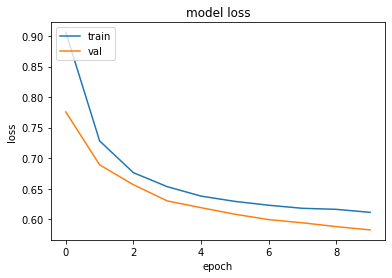

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inspecting what the network has learned

tf.Tensor(1.3719418, shape=(), dtype=float32)
tf.Tensor(1.3045418, shape=(), dtype=float32)
tf.Tensor(1.3134549, shape=(), dtype=float32)


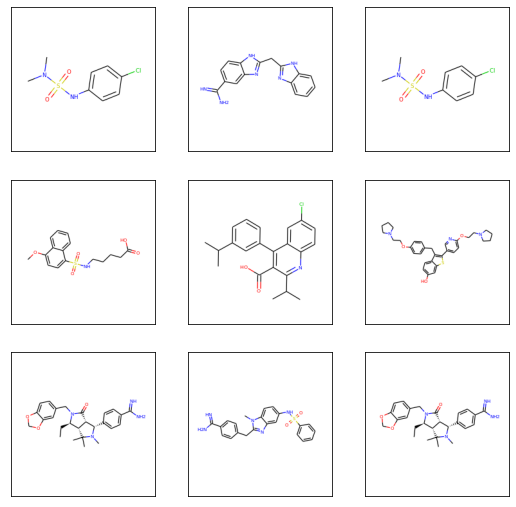

In [81]:
sample = next(iter(val_dl))
visualize2(*sample)

anchor, positive, negative, _ = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [82]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9988131
Negative similarity 0.95865756


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
#import sklearn, pandas as pd, seaborn as sn
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load models
#model = embedding
model = siamese_model

names = next(iter(val_dl))

anchor, positive, negative, rmsd = names
anchor = tf.reshape(anchor[0], (1, 224, 224, 3))
positive = tf.reshape(positive[0], (1, 224, 224, 3))
negative = tf.reshape(negative[0], (1, 224, 224, 3))
rmsd = tf.reshape(rmsd[0], (1, 1))


test_im = []
test_im.append(anchor)
test_im.append(positive)
test_im.append(negative)

print(test_im[0].shape)
_, r,c,_ = test_im[0].shape
print(test_im[0].shape)
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))

test_im = 1 - test_im/255

# Predict
pred = model.predict([anchor, positive, negative, rmsd])

print(pred)

num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

# Parameter optimization 

In [ ]:
def create_embedding(dropout = None):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape +  (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    if dropout != None: 
        layer = layers.Dropout(dropout)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    return embedding

In [ ]:
def create_siamese_net(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

    return siamese_network

In [ ]:
def train_model(epochs = 5, lr=0.0001, margin = 1.5, dropout=None, verbose=False):
    embedding = create_embedding(dropout=dropout)
    siamese_network = create_siamese_net(embedding)
    siamese_model = SiameseModel(siamese_network, margin=margin)
    siamese_model.compile(optimizer=optimizers.Adam(learning_rate=lr), metrics=[metrics.RootMeanSquaredError(name='rmse')])
    model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=epochs)
    if verbose:
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(model.history['val_rmse'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['rmse'], loc='upper left')
        plt.show()
    return siamese_model
        
    

# Test the model performance on instances

In [83]:
from tensorflow.keras import models

In [85]:
siamese_model.compute_output_shape(input_shape= [(None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3), (None, 1)])                        

(TensorShape([None]), TensorShape([None]), TensorShape([None, 1]))

In [87]:
siamese_model.save('models/siamese_model')

2022-02-24 16:07:33.851329: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/siamese_model/assets


In [88]:
model = models.load_model('models/siamese_model')

In [89]:
sample = next(iter(val_dl))

In [90]:
docked_sample = valid.iloc[0]
docked_sample.docked

'1K22_MEL'

In [91]:
docked_image = preprocess_image(docked_sample.img_docked)

### Sort the templates for one docked molecule by order of lowest rmsd

In [92]:
templates = valid[valid.docked == docked_sample.docked]
templates = templates.reset_index()
templates = templates.sort_values(by=['rmsd'], ignore_index=True)
templates

,index,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,...,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid,img_temp,img_docked
0,1122,1O0D_163,1K22_MEL,0.852,P00734,Cn1c(CNC(=O)c2cccn2C(=O)[C@@H](CC2CCCCC2)NCC(=...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]:[#6]:[#6]:[#6]-[#6]-[#7]...,33,6,...,10,0.339506,0.418301,-0.160169,1,1.395062,1.183007,True,1O0D_163.png,1K22_MEL.png
1,291,1C1V_BAB,1K22_MEL,1.457,P00734,NC(=[NH2+])c1ccc2nc(Cc3[nH]c4cc(C(N)=[NH2+])cc...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#7]-[#6]-[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7]:,...",25,11,...,4,0.102273,0.108571,0.376380,1,-0.977273,-1.914286,True,1C1V_BAB.png,1K22_MEL.png
2,3011,3SI4_B04,1K22_MEL,1.485,P00734,C[n+]1ccccc1CNC(=O)[C@@H]1CCCN1C(=O)[C@H](N)Cc...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#6]:,-[#6]:[#6]:[#6]:[#6]-[#6]-[#7]-[#6](=[#8...",27,3,...,8,0.248447,0.340000,0.395415,1,0.484472,0.400000,True,3SI4_B04.png,1K22_MEL.png
3,3168,1SL3_170,1K22_MEL,1.944,P00734,O=C(Cn1c(Cl)cnc(NCC(F)(F)c2cccc[n+]2[O-])c1=O)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]-[...,37,2,...,8,0.093023,0.129808,0.664748,1,-1.069767,-1.701923,True,1SL3_170.png,1K22_MEL.png
4,1746,4UFG_D6J,1K22_MEL,3.020,P00734,CC[C@@H](C(=O)NCc1ccc(C(=N)N)cc1)N(C)C(=O)[C@@...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,39,5,...,8,0.229167,0.356322,1.105257,3,0.291667,0.563218,True,4UFG_D6J.png,1K22_MEL.png
5,3038,2ZFP_19U,1K22_MEL,3.068,P00734,CC[C@@H](N)C(=O)N1CCC[C@H]1C(=O)NCc1cccc(Cl)c1,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]-[#6]-[#6](-[#7])-[#6](=[#8])-[#7](-[#6])-...,22,3,...,7,0.294964,0.440000,1.121026,3,0.949640,1.400000,True,2ZFP_19U.png,1K22_MEL.png
6,1129,2ZGB_21U,1K22_MEL,3.170,P00734,CC(C)C[C@@H](N)C(=O)N1CCC[C@H]1C(=O)NCc1cccc(C...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]-[#6]-[#6]-[#6](-[#7])-[#6](=[#8])-[#7](-[...,24,3,...,7,0.282759,0.453125,1.153732,3,0.827586,1.531250,True,2ZGB_21U.png,1K22_MEL.png
7,2464,1C1W_BAH,1K22_MEL,3.931,P00734,NC(=[NH2+])c1ccc2nc(C(O)(O)c3nc4ccc(C(N)=[NH2+...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#7]-[#6]-[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7]:,...",27,12,...,4,0.100000,0.112360,1.368894,3,-1.000000,-1.876404,True,1C1W_BAH.png,1K22_MEL.png
8,3026,2C8W_C7M,1K22_MEL,4.330,P00734,COc1ccc(S(=O)(=O)NC[C@@H](O)[C@H](Cc2ccccc2)[N...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#6](-[#7])-[#6]:,-[#6]:,-[#6]:,-[#6](-,:[#6])...",37,6,...,2,0.087963,0.169154,1.465568,3,-1.120370,-1.308458,True,2C8W_C7M.png,1K22_MEL.png
9,0,1YPJ_UIB,1K22_MEL,4.643,P00734,CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,33,3,...,7,0.165775,0.289941,1.535361,3,-0.342246,-0.100592,True,1YPJ_UIB.png,1K22_MEL.png


In [93]:
template_image = preprocess_image(templates.iloc[0].img_temp)

Show docked molecule


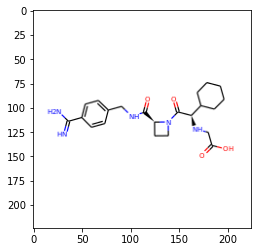

In [94]:
print('Show docked molecule')
plt.imshow(docked_image)

Show lowest rmsd template molecule


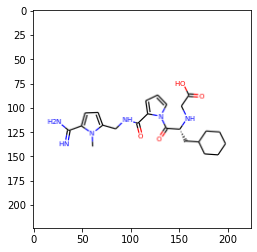

In [95]:
print('Show lowest rmsd template molecule')
plt.imshow(template_image)

In [96]:
rmsds = templates.log_RMSD
rmsds

0    -0.160169
1     0.376380
2     0.395415
3     0.664748
4     1.105257
5     1.121026
6     1.153732
7     1.368894
8     1.465568
9     1.535361
10    1.636080
11    2.084056
12    2.106570
13    2.213972
14    2.225272
15    2.290715
16    2.349850
17    2.384442
18    2.539947
Name: log_RMSD, dtype: float64

In [97]:
rmse = metrics.RootMeanSquaredError()

In [98]:
similarity = metrics.CosineSimilarity()

In [99]:
tf_template = tf.reshape(template_image, (1,224,224,3))

In [100]:
tf_docked = tf.reshape(docked_image, (1,224,224,3))

In [101]:
template_embedding, docked_embedding = (
    embedding(resnet.preprocess_input(tf_template)),
    embedding(resnet.preprocess_input(tf_docked)),
)

In [102]:
rmse_positive = rmse(template_embedding, docked_embedding)
rmse_positive.numpy(), templates.iloc[0].log_RMSD

(0.0023399994, -0.160168752152821)

In [103]:
type(rmse_positive.numpy())

numpy.float32

In [104]:
def get_rmse(row):
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,224,224,3))
    docked_image = tf.reshape(docked_image, (1,224,224,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    rmse_positive = rmse(template_embedding, docked_embedding)
    return rmse_positive.numpy()

In [105]:
rmses = {}
for i, r in templates.iterrows(): 
    rm = get_rmse(r)
    rmses[i] = rm
rmses

{0: 0.0023399994,
 1: 0.005698462,
 2: 0.0066207866,
 3: 0.005965072,
 4: 0.00612626,
 5: 0.005885947,
 6: 0.0056740325,
 7: 0.005484035,
 8: 0.0052367495,
 9: 0.004998977,
 10: 0.005310619,
 11: 0.005151125,
 12: 0.0055532414,
 13: 0.0056677395,
 14: 0.0055421274,
 15: 0.005391748,
 16: 0.005280013,
 17: 0.0051968824,
 18: 0.0051520807}

In [106]:
rmses_sorted = sorted(rmses, key=rmses.get)
rmses_sorted

[0, 9, 11, 18, 17, 8, 16, 10, 15, 7, 14, 12, 13, 6, 1, 5, 3, 4, 2]

In [107]:
min(rmses.values())

0.0023399994

In [108]:
from scipy.stats import pearsonr

In [109]:
df1 = pd.DataFrame(rmsds)
df1

,log_RMSD
0,-0.160169
1,0.376380
2,0.395415
3,0.664748
4,1.105257
5,1.121026
6,1.153732
7,1.368894
8,1.465568
9,1.535361


In [110]:
df2 = pd.DataFrame.from_dict(rmses, orient='index')
df2 = df2.rename(columns={0:'rmse'})
df2

,rmse
0,0.002340
1,0.005698
2,0.006621
3,0.005965
4,0.006126
5,0.005886
6,0.005674
7,0.005484
8,0.005237
9,0.004999


In [111]:
df_full = pd.concat([df1, df2], axis=1 , ignore_index=False)
df_full

,log_RMSD,rmse
0,-0.160169,0.002340
1,0.376380,0.005698
2,0.395415,0.006621
3,0.664748,0.005965
4,1.105257,0.006126
5,1.121026,0.005886
6,1.153732,0.005674
7,1.368894,0.005484
8,1.465568,0.005237
9,1.535361,0.004999


In [112]:
full_correlation = pearsonr(df_full['rmse'], df_full['log_RMSD'])
print('Correlation coeffiecient', full_correlation[0])
print('P-value: ', full_correlation[1])

Correlation coeffiecient 0.16975237252533548
P-value:  0.48720034502465015


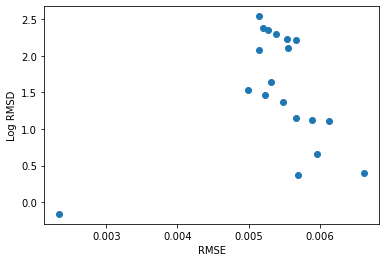

In [113]:
plt.scatter(df_full['rmse'], df_full['log_RMSD'])
plt.xlabel('RMSE')
plt.ylabel('Log RMSD')
plt.show()

# Check for the whole test set

In [ ]:
def get_templates(docked):
    
    

In [115]:
test = valid

In [ ]:
docked_unique = test